In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scarlet
import logging

import tensorflow_hub as hub
import tensorflow as tf
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)

In [3]:
import proxmin
import proxmin.operators

In [4]:
module_path='modules/pixelcnn_wfirst'
pixelcnn = hub.Module(module_path)
sess= tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Building a blend object
import galsim
import galsim.wfirst as wfirst

data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
cat = galsim.COSMOSCatalog(dir=data_dir)

In [7]:
random_seed = 123456

# Generation script based on demo13.py
rng = galsim.BaseDeviate(random_seed)
poisson_noise = galsim.PoissonNoise(rng)

filters = wfirst.getBandpasses(AB_zeropoint=True)

In [8]:
# Let's remove a few filters for which our morphology model doesn't have enough resolution
filters = {i: filters[i] for i in ['J129']}#,J129 'H158', 'F184', 'W149']}

use_SCA = 7
filters = wfirst.getBandpasses(AB_zeropoint=True)
PSFs = {}
for filter_name, filter_ in filters.items():
    PSFs[filter_name] = wfirst.getPSF(use_SCA, wavelength=filter_, approximate_struts=True, n_waves=10)

In [9]:
ra_targ = 90.*galsim.degrees
dec_targ = -10.*galsim.degrees
targ_pos = galsim.CelestialCoord(ra=ra_targ, dec=dec_targ)

pos_rng = galsim.UniformDeviate(random_seed)
wcs_list = wfirst.getWCS(world_pos=targ_pos, SCAs=use_SCA)
wcs = wcs_list[use_SCA]

SCA_cent_pos = wcs.toWorld(galsim.PositionD(wfirst.n_pix/2, wfirst.n_pix/2))

# # We randomly distribute points in (X, Y) on the CCD.
# # If we had a real galaxy catalog with positions in terms of RA, dec we could use wcs.toImage()
# # to find where those objects should be in terms of (X, Y).
# pos_rng = galsim.UniformDeviate(random_seed)

In [10]:
# Make a list of (X, Y, F814W magnitude, n_rot, flip) values.
# (X, Y) give the position of the galaxy centroid (or the center of the postage stamp into which
# we draw the galaxy) in the big image.
# F814W magnitudes are randomly drawn from the catalog, and are used to create a more realistic
# flux distribution for the galaxies instead of just having the 10 flux values for the galaxies
# we have chosen to draw.
# n_rot says how many 90 degree rotations to include for a given realization of each galaxy, so
# it doesn't appear completely identical each time we put it in the image.
# flip is a random number that will determine whether we include an x-y flip for this appearance
# of the galaxy or not.
x_stamp = []
y_stamp = []
n_rot_stamp = []
flip_stamp = []
gals = []
n_tot=3
n_pix=65

hst_eff_area = 2.4**2 * (1.-0.33**2)
wfirst_eff_area = galsim.wfirst.diameter**2 * (1.-galsim.wfirst.obscuration**2)
flux_scaling = (wfirst_eff_area/hst_eff_area) * wfirst.exptime 

random_seed = 1123

rng = galsim.BaseDeviate(random_seed)
poisson_noise = galsim.PoissonNoise(rng)
pos_rng = galsim.UniformDeviate(random_seed)

gal_ids = [71526, 80012,71535, 71526,  71523,  71519]


for i_gal in range(n_tot):
    x_pos = 15*(pos_rng() - 0.5)
    y_pos = 15*(pos_rng() - 0.5)
    x_stamp.append(x_pos)
    y_stamp.append(y_pos)
    gal_ind = gal_ids[i_gal]#int(pos_rng()*10000)+70000
    gal = cat.makeGalaxy(gal_ind, gal_type='real')  
    gals.append(gal)

In [11]:
psf = galsim.Gaussian(fwhm=0.14)

In [12]:
# Draw galaxies in each bands
imgs = []
for filter_name, filter_ in filters.items():
    final_image = galsim.ImageF(n_pix,n_pix, scale=wfirst.pixel_scale)
    objs = []
    for i_gal in range(n_tot):
        final = flux_scaling*gals[i_gal]
        final = final.shift(dx=x_stamp[i_gal]*0.11,dy=y_stamp[i_gal]*0.11)
        objs.append(final)
    
    f = galsim.Convolve(galsim.Add(objs), psf)#PSFs[filter_name][use_SCA])
    f.drawImage(final_image)
    
    sky_level = wfirst.getSkyLevel(filters[filter_name], world_pos=SCA_cent_pos)
    sky_level *= (1.0 + wfirst.stray_light_fraction)
    sky_image = final_image.copy()
    
    wcs.makeSkyImage(sky_image, sky_level)
    sky_image += wfirst.thermal_backgrounds[filter_name]*wfirst.exptime
    final_image += sky_image
    
    final_image.addNoise(poisson_noise)
    final_image -= sky_image
    imgs.append(final_image)

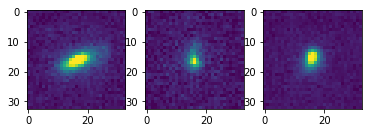

In [13]:
im1 = galsim.Image(33, 33, scale=0.11)
im2 = galsim.Image(33, 33, scale=0.11)
im3 = galsim.Image(33, 33, scale=0.11)

galsim.Convolve(gals[0] , PSFs[filter_name][use_SCA]).drawImage(im1)
galsim.Convolve(gals[1], PSFs[filter_name][use_SCA]).drawImage(im2)
galsim.Convolve(gals[2], PSFs[filter_name][use_SCA]).drawImage(im3);
subplot(131)
imshow(im1.array,vmin=-0.03,vmax=0.5)
subplot(132)
imshow(im2.array,vmin=-0.03,vmax=0.5)
subplot(133)
imshow(im3.array,vmin=-0.03,vmax=0.5)

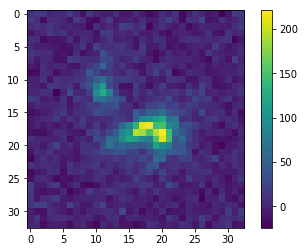

In [14]:
imshow(imgs[0].array[16:-16,16:-16]); colorbar()

In [15]:
class PixelCNNConstraint(scarlet.Constraint):
    
    def __init__(self, module, session):
        self.x = tf.placeholder(shape=(1,32,32,1), dtype=tf.float32)
        self.pixelcnn = module(self.x, as_dict=True)['grads']
        self.session = session

    def prox_pixelcnn(self, X, step):
        x = X[1:,1:].reshape((1,32,32,1))
        u = zeros_like(x)+x
                
        for i in range(20):
            u += 0.00001*((x - u) - 50*step*self.session.run(self.pixelcnn, feed_dict={self.x: u}))
        
        return np.pad(u[0,:,:,0],((1,0), (1,0)), mode='wrap')

    def prox_sed(self, shape):
        return proxmin.operators.prox_plus

    def prox_morph(self, shape):
        return self.prox_pixelcnn

In [16]:
# # Computing effective PSF
# reference_psf = galsim.Deconvolve(galsim.Gaussian(fwhm=0.3))
# diff_kernel = galsim.Convolve(galsim.Convolve(PSFs['Y106'][use_SCA], galsim.Gaussian(fwhm=0.14)))

imKernel = galsim.Image(33, 33, scale=0.11)
psf.drawImage(imKernel)
psf = imKernel.array / imKernel.array.sum()

In [17]:
# imshow(psf,cmap='gist_stern'); colorbar();

In [18]:
config = scarlet.Config(source_sizes=[33], accelerated=False)

In [19]:
img = imgs[0].array / flux_scaling  # Apply scaling to get back on cosmos reference 

In [43]:
from astropy.io import fits
fits.writeto('test_image2.fits', img)

In [22]:
img = img.reshape((1,65,65))
sources = [scarlet.ExtendedSource((32+y_stamp[0], 32+x_stamp[0]), img, bg_rms=array([0.1]), config=config, shift_center=0, normalization=None, fix_sed=True, fix_frame=True, symmetric=True, monotonic=True, constraints=PixelCNNConstraint(pixelcnn, sess),), # 
           scarlet.ExtendedSource((32+y_stamp[1], 32+x_stamp[1]), img, bg_rms=array([0.1]), config=config, shift_center=0, normalization=None, fix_sed=True, fix_frame=True, symmetric=True, monotonic=True, constraints=PixelCNNConstraint(pixelcnn, sess),),
           scarlet.ExtendedSource((32+y_stamp[2], 32+x_stamp[2]), img, bg_rms=array([0.1]), config=config, shift_center=0, normalization=None, fix_sed=True, fix_frame=True, symmetric=True, monotonic=True, constraints=PixelCNNConstraint(pixelcnn, sess),),
          ]#  constraints=PixelCNNConstraint(pixelcnn, sess),

blend = scarlet.Blend(sources).set_data(img, config=config)

INFO:scarlet.blend:max source size 33 smaller than image size (65,65); truncation possible


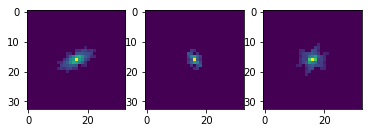

In [23]:
subplot(131)
imshow(sources[0][0].morph)
subplot(132)
imshow(sources[1][0].morph)
subplot(133)
imshow(sources[2][0].morph)

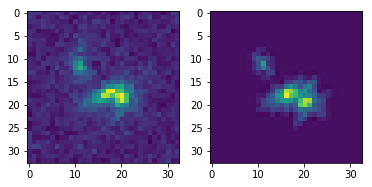

In [24]:
subplot(121)
imshow(imgs[0].array[16:-16,16:-16]);
subplot(122)
imshow(blend.get_model()[0][16:-16,16:-16]);

(33, 33)

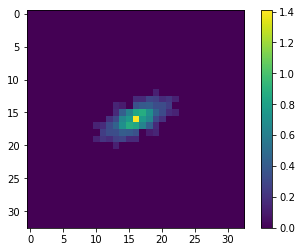

In [25]:
imshow(sources[0][0].morph)
colorbar()
sources[0][0].morph.shape

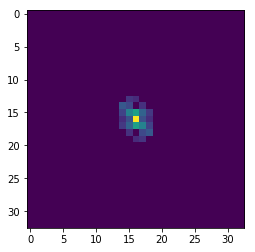

In [26]:
plt.figure()
plt.imshow(sources[1][0].morph)
plt.show()

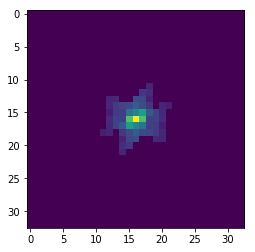

In [27]:
plt.figure()
plt.imshow(sources[2][0].morph)
plt.show()

In [28]:
blend.fit(steps=400, e_rel=1e-6)

DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:No component centers updated
DEBUG:scarlet.blend:

KeyboardInterrupt: 

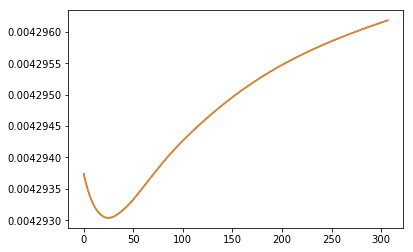

In [29]:
plot(blend.mse[20:])

In [30]:
blend.get_model().shape

(1, 65, 65)

Text(0.5, 1.0, 'Residuals')

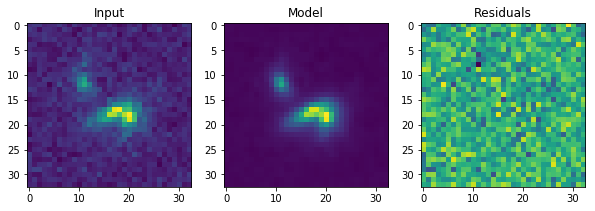

In [31]:
figure(figsize=(10,7))
subplot(131)
imshow(img[0][16:-16,16:-16])
title('Input')
subplot(132)
imshow(blend.get_model()[0][16:-16,16:-16])
title('Model')
subplot(133)
imshow(blend.get_model()[0][16:-16,16:-16] - img[0][16:-16,16:-16])
title('Residuals')

Text(0.5, 1.0, 'Residuals')

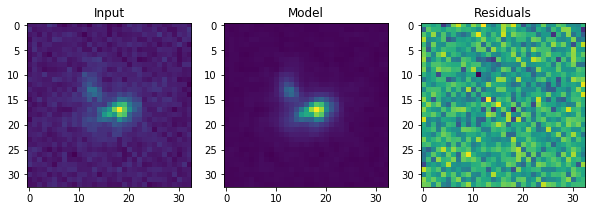

In [45]:
figure(figsize=(10,7))
subplot(131)
imshow(img[0][16:-16,16:-16])
title('Input')
subplot(132)
imshow(blend.get_model()[0][16:-16,16:-16])
title('Model')
subplot(133)
imshow(blend.get_model()[0][16:-16,16:-16] - img[0][16:-16,16:-16])
title('Residuals')

Text(0.5, 1.0, 'True galaxy')

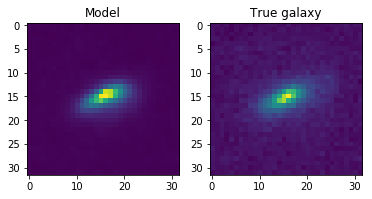

In [32]:
subplot(121)
imshow(blend.components[0].morph[1:,1:])
title('Model')
subplot(122)
imshow(im1.array[1:,1:])
title('True galaxy')

Text(0.5, 1.0, 'True galaxy')

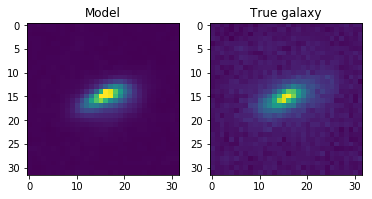

In [42]:
subplot(121)
imshow(blend.components[0].morph[1:,1:],vmax=0.9)
title('Model')
subplot(122)
imshow(im1.array[1:,1:],vmax=0.9)
title('True galaxy')

Text(0.5, 1.0, 'True galaxy')

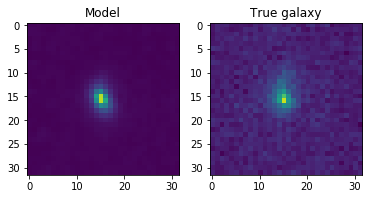

In [38]:
subplot(121)
imshow(blend.components[1].morph[1:,1:],vmax=0.7)
title('Model')
subplot(122)
imshow(im2.array[1:,1:],vmax=0.7)
title('True galaxy')

Text(0.5, 1.0, 'True galaxy')

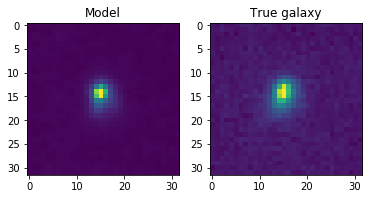

In [37]:
subplot(121)
imshow(blend.components[2].morph[1:,1:],vmax=0.7)
title('Model')
subplot(122)
imshow(im3.array[1:,1:],vmax=0.7)
title('True galaxy')